This is the first draft of the Gaussian Likelihood compressor, a tool which takes some data as an input, and compresses them to a lower dimensional space where the likelihood is simply Gaussian.

In this notebook, you can find 3 tools: first of all, a way to generate the data in order to perform your experiments. 

Then, a compressor, which at this stage could either be an auto-encoder, an Information Maximising Neural Network, or Score Compression in all its various forms.

Finally, we apply a Normalising Flow to map it to a standard Gaussian.

# Data generation

In [1]:
# we write here the script to create our dataset, taken primarily from zupcx26 code
# we will add modules to import progressively 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

def find_level(nums, level):
    """
    Function to find confidence levels 
    """
    sum = 0
    for num in nums:
        sum += num
        if sum > level:
            return num
        
def lognorm(data, mean, sigma):
    """
    Function to draw the posterior from samples
    """
    pref = data*np.sqrt(2*np.pi) * sigma
    expo = np.exp(-(np.log(data)-mean)**2 / (2*sigma**2))
    return expo/pref

def real_post(sigma, mean, obs):
    """
    Function to draw the real posterior for the toy model only
    """
    pref = obs*np.sqrt(2*np.pi) * sigma
    expo = np.exp(-(np.log(obs)-mean)**2 / (2*sigma**2))
    evidence = 1 #inc_gamma(0, np.log(obs)**2 / 2) / (2*obs*np.sqrt(2*np.pi))
    return (expo/pref)/(evidence)

%matplotlib inline

In [3]:
# we define a few hyper parameters here
n = 1000 # total number of datapoints
n_class = 20 # number of different cosmologies for the training
# maybe it is better to use a linear sampling scheme?
epsilon = 0.0001
q_prior = np.linspace(epsilon, 1.000-epsilon, n_class) # avoiding the 0 value by adding a small epsilon
q_fid = q_prior[n_class//2]  # fiducial parameter for training; it is chosen to be the central one
preprocess = True  # whether to preprocess the data or not

In [4]:
n_vec = 50 # number of components of the data
d_vec = []
for _ in range(3*n):
    d_vec.append([np.random.lognormal(q_fid, (i/n_vec)/100.0, 1) for i in range(n_vec)])

# we create the observed data point, for now at the fiducial value of q
d_vec_obs = []
for _ in range(1):
    d_vec_obs.append([np.random.lognormal(q_fid, (i/n_vec)/100.0, 1) for i in range(n_vec)])

# we also create the data corresponding to a fixed noise, but different q
# together with that, we also create the FN data vectors for the posterior
d_vec_q = []
d_vec_q_posterior = []
for q in q_prior:
    np.random.seed(13)
    d_vec_q.append([np.random.lognormal(q, (i/n_vec)/100.0, 1) for i in range(n_vec)])
n_bins = 5000 # number of points in which to evaluate the posterior
q_posterior = np.linspace(epsilon, 1.000-epsilon, n_bins)
for q in q_posterior:
    np.random.seed(13)
    d_vec_q_posterior.append([np.random.lognormal(q, (i/n_vec)/100.0, 1) for i in range(n_vec)])

# and also for testing and validation purposes
d_vec_q_test = []
for q in q_prior:
    np.random.seed(14) # a different seed to check whether the algorithm is good at generalising
    d_vec_q_test.append([np.random.lognormal(q, (i/n_vec)/100.0, 1) for i in range(n_vec)])
    
d_vec_q_valid = []
for q in q_prior:
    np.random.seed(15)
    d_vec_q_valid.append([np.random.lognormal(q, (i/n_vec)/100.0, 1) for i in range(n_vec)])

d_vec = np.reshape(np.asarray(d_vec), [-1, n_vec])
d_vec_obs = np.reshape(np.asarray(d_vec_obs), [-1, n_vec])
d_vec_obs_keep = np.copy(d_vec_obs)
d_vec_q = np.reshape(np.asarray(d_vec_q), [-1, n_vec])
d_vec_q_posterior = np.reshape(np.asarray(d_vec_q_posterior), [-1, n_vec])
d_vec_q_test = np.reshape(np.asarray(d_vec_q_test), [-1, n_vec])
d_vec_q_valid = np.reshape(np.asarray(d_vec_q_valid), [-1, n_vec])
print(d_vec.shape, d_vec_q.shape, d_vec_q_posterior.shape)

if preprocess:
    pre_fac = 1.0
    def preprocess_data(d, M, m, pre_fac=1.0):
        return pre_fac*(d-m)/(M-m)
    minimum, maximum = d_vec_q.min(), d_vec_q.max()
    d_vec = preprocess_data(d_vec, minimum, maximum, pre_fac = pre_fac)
    d_vec_obs = preprocess_data(d_vec_obs, minimum, maximum, pre_fac = pre_fac)
    d_vec_q = preprocess_data(d_vec_q, minimum, maximum, pre_fac = pre_fac)
    d_vec_q_test = preprocess_data(d_vec_q_test, minimum, maximum, pre_fac = pre_fac)
    d_vec_q_valid = preprocess_data(d_vec_q_valid, minimum, maximum, pre_fac = pre_fac)
    d_vec_q_posterior = preprocess_data(d_vec_q_posterior, minimum, maximum, pre_fac = pre_fac)   

(3000, 50) (20, 50) (5000, 50)


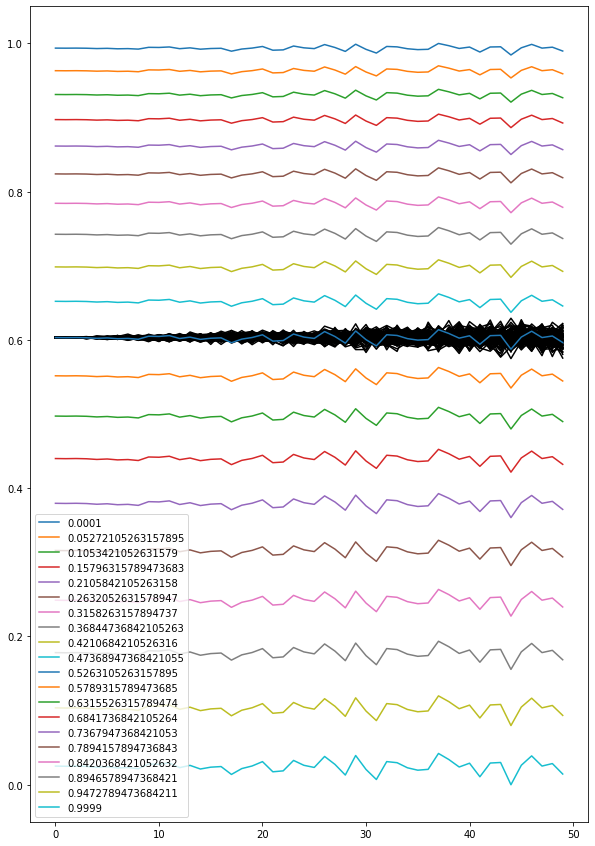

In [5]:
# we plot a few things to make sure everything is good
plt.figure(figsize=(10, 15))
for index in range(100):
    plt.plot(np.arange(n_vec), d_vec[index], color='k')
    #plt.semilogy(np.arange(n_vec), d_vec_q[index], label=q_prior[index])
for index in range(n_class):
    #plt.semilogy(np.arange(n_vec), np.mean(d_vec[index::n_class], axis=0), label=q_prior[index])
    #plt.plot(np.arange(n_vec), d_vec_q_posterior[index], label=q_posterior[index])
    plt.plot(np.arange(n_vec), d_vec_q[index], label=q_prior[index])

plt.legend()


# Compression

## Autoencoder (AE)

In this case, since we are using an auto-encoder, we devise it such that:
- we minimise the L2 loss between the noisy realisation, with an additional bit on the variance;
- we minimise the L2 loss between the fixed-noise (fn) realisations;
- we optimise different part of the encoder-decoder with different losses;
- we do not care about the latent space distribution at this stage.

Problems of this compression include the fact that the L2 loss is too general.
As a pro, we do retain the capability of checkin the reconstruction in this case.

In [6]:
# we define the encoder and the decoder here
# there are some hyperparameters at the beginning; also, the dropout layers may be added upon need

activation_enc = 'relu'
activation_dec = 'relu'
batch_s = 128

def encoder(data, bs=batch_s, rate=0.0, is_reuse=False):
    with tf.variable_scope('noise_encoder') as scope:
        if is_reuse is True:
            scope.reuse_variables()
        x = tf.reshape(data, shape=[-1, n_vec])
        dense1 = tf.layers.dense(x, 512, activation=getattr(tf.nn, activation_enc))
        dense2 = tf.layers.dense(dense1, 128, activation=getattr(tf.nn, activation_enc))
        dense3 = tf.layers.dense(dense2, 16, activation=getattr(tf.nn, activation_enc))
    with tf.variable_scope('fixed_noise_encoder') as scope:
        if is_reuse is True:
            scope.reuse_variables()    
        dense4 = tf.layers.dense(dense3, 1)
        out = tf.reshape(dense4, [-1, 1])
    return out

def decoder(data, bs=batch_s, rate=0.0, is_reuse=False):
    with tf.variable_scope('fixed_noise_decoder') as scope:
        if is_reuse is True:
            scope.reuse_variables()
        x = tf.reshape(data, shape=[-1, 1])
        dense1 = tf.layers.dense(x, 16, activation=getattr(tf.nn, activation_dec))
    with tf.variable_scope('noise_decoder') as scope:
        if is_reuse is True:
            scope.reuse_variables()
        dense2 = tf.layers.dense(dense1, 128, activation=getattr(tf.nn, activation_dec))
        dense3 = tf.layers.dense(dense2, 512, activation=getattr(tf.nn, activation_dec))
        dense4 = tf.layers.dense(dense3, n_vec)
        out = tf.reshape(dense4, [-1, n_vec])
    return out

def next_batch(data1, data2, num1, num2, shuffle=True):
    """
    Return a total of 'num-i' random samples
    """
    if not shuffle:
      return np.asarray(data1), np.asarray(data2)
    idx = np.arange(len(data1))
    np.random.shuffle(idx)
    idx = idx[:num1]
    data1_shuffle = [data1[i] for i in idx]
    idx = np.arange(len(data2))
    np.random.shuffle(idx)
    idx = idx[:num2]
    data2_shuffle = [data2[i] for i in idx]
    return np.asarray(data1_shuffle), np.asarray(data2_shuffle),


In [7]:
# we set up the network and train
# divide data in train and validation - test will come after
noise_cls_train = d_vec[:n, :]
noise_cls_valid = d_vec[n:2*n, :]
noise_cls_test = d_vec[2*n:, :]

real_cls_train = d_vec_q
real_cls_valid = d_vec_q_valid
real_cls_test = d_vec_q_test

# just check that the split was successful
print('Train data shape: ', noise_cls_train.shape)
print('Valid data shape: ', noise_cls_valid.shape)

# to void problems with the notebook
tf.reset_default_graph()

# creating the network
noise_data = tf.placeholder(tf.float32, [None, n_vec], name='noise_cls')
real_data = tf.placeholder(tf.float32, [n_class, n_vec], name='real_cls')
drop_rate = tf.placeholder(tf.float32)  # needed in case of dropout
lr = tf.placeholder(tf.float32)

# define the model
# noise data encoder
z = encoder(noise_data, rate=drop_rate)
# noise data decoder
noise_data_tilde = decoder(z, rate=drop_rate)
# real data encoder
z_real = encoder(real_data, bs = n_class, rate=drop_rate, is_reuse=True)
# real data decoder
real_data_tilde = decoder(z_real, bs = n_class, rate=drop_rate, is_reuse=True)

Train data shape:  (1000, 50)
Valid data shape:  (1000, 50)
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [8]:
# defines the losses, and the parameters to optimise on
with tf.name_scope('z_auto_enc_loss'):
    var_hat = tf.math.reduce_std(noise_data_tilde, axis=[0])
    var = tf.math.reduce_std(noise_data, axis=[0])
    var_reg = tf.reduce_sum(tf.square(var-var_hat))  #tf.constant(0.0) 
    autoenc_loss = 1.0 * tf.reduce_mean(tf.reduce_sum(tf.square(noise_data - noise_data_tilde), axis=[1])) + 1.0*var_reg
    tf.summary.scalar('var_reg', var_reg)
    tf.summary.scalar('auto_enc_loss', autoenc_loss)
with tf.name_scope('real_auto_enc_loss'):
    real_autoenc_loss = 1.0 * tf.reduce_mean(tf.reduce_sum(tf.square(real_data - real_data_tilde), axis=[1]))
    tf.summary.scalar('real_autoenc_loss', real_autoenc_loss)

# variables to optimise on
autoenc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='noise_encoder') + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='noise_decoder')
real_autoenc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='fixed_noise_encoder') + tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='fixed_noise_decoder')

# optimisation
with tf.name_scope('train'):
    optimize_autoenc = tf.train.AdamOptimizer(learning_rate = lr, beta1=0.5, beta2=0.9).minimize(autoenc_loss, var_list=autoenc_vars)
    optimize_real_autoenc = tf.train.AdamOptimizer(learning_rate = lr, beta1=0.5, beta2=0.9).minimize(real_autoenc_loss, var_list=real_autoenc_vars)

In [9]:
# now we train the AE
# getting ready to train
merged = tf.summary.merge_all()
saver = tf.train.Saver(max_to_keep=None)
init = tf.initialize_all_variables()
learning_rate = 1e-4
n_iter = 1000

print("Defined the data and the model, starting training")
print('Starting session')
#with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
sess = tf.Session()
sess.run(init)
train_writer = tf.summary.FileWriter('./train', sess.graph, filename_suffix='train')
test_writer = tf.summary.FileWriter('./test', sess.graph, filename_suffix='test')
for iteration in range(n_iter):
    # save the learning curves
    feed_train_noise_cls, feed_train_real_cls = next_batch(noise_cls_train, real_cls_train, batch_s, n_class)
    feed = {noise_data: feed_train_noise_cls.reshape([-1, n_vec]),
       real_data: feed_train_real_cls.reshape([-1, n_vec]),
       drop_rate: 0.0, lr: learning_rate}
    summary, train_autoenc_loss, train_var_reg, train_real_autoenc_loss = sess.run([merged, autoenc_loss, var_reg, real_autoenc_loss], feed_dict=feed)
    train_writer.add_summary(summary, iteration)
    feed_valid_noise_cls, feed_valid_real_cls = next_batch(noise_cls_valid, real_cls_valid, batch_s, n_class)
    feed = {noise_data: feed_valid_noise_cls.reshape([-1, n_vec]),
      real_data: feed_valid_real_cls.reshape([-1, n_vec]),
      drop_rate: 0.0, lr: learning_rate}
    summary, test_autoenc_loss, test_var_reg, test_real_autoenc_loss = sess.run([merged, autoenc_loss, var_reg, real_autoenc_loss], feed_dict=feed)
    test_writer.add_summary(summary, iteration)
    if iteration % 100 == 0:
        print('Iteration', iteration+1, '/', n_iter, 'autoenc loss', test_autoenc_loss, 'var reg', test_var_reg, 'real autoenc loss', test_real_autoenc_loss)
    # we first train the autoencoder based on the noise
    feed_train_noise_cls, feed_train_real_cls = next_batch(noise_cls_train, real_cls_train, batch_s, n_class)
    feed = {noise_data: feed_train_noise_cls.reshape([-1, n_vec]),
        real_data: feed_train_real_cls.reshape([-1, n_vec]),
        drop_rate: 0.0, lr: learning_rate}
    sess.run(optimize_autoenc, feed)
    # then we train the label encoder on the same batch
    #feed_train_noise_cls, feed_train_real_cls = next_batch(noise_cls_train, real_cls_train, batch_s, n_class)
    feed = {noise_data: feed_train_noise_cls.reshape([-1, n_vec]),
        real_data: feed_train_real_cls.reshape([-1, n_vec]),
        drop_rate: 0.0, lr: learning_rate}
    sess.run(optimize_real_autoenc, feed)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Defined the data and the model, starting training
Starting session
Iteration 1 / 1000 autoenc loss 18.186066 var reg 0.0014956412 real autoenc loss 21.366346
Iteration 101 / 1000 autoenc loss 0.0053175706 var reg 0.0011369166 real autoenc loss 0.029475164
Iteration 201 / 1000 autoenc loss 0.003138346 var reg 0.0011391763 real autoenc loss 0.025544956
Iteration 301 / 1000 autoenc loss 0.0056326864 var reg 0.0010874867 real autoenc loss 0.028678343
Iteration 401 / 1000 autoenc loss 0.0026063616 var reg 0.0010902081 real autoenc loss 0.01730931
Iteration 501 / 1000 autoenc loss 0.0030600345 var reg 0.0011384578 real autoenc loss 0.013242969
Iteration 601 / 1000 autoenc loss 0.0027415399 var reg 0.0010948023 real autoenc loss 0.0119016515
Iteration 701 / 1000 autoenc loss 0.0050148508 var reg 0.0011473178 real autoenc loss 0.010148789
Iteration 801 / 1000 autoenc loss 0.0025976433 var reg 0.0010815997 real autoenc lo

In [10]:
# we need to retrieve all the needed summaries here, so:
# 1) the summary of the observation
# 2) the summaries of the posterior points
# 3) the summaries of the fixed noise vectors
# 4) the summaries of the noise realisations at the fiducial point
feed_test_noise_cls, feed_test_real_cls = next_batch(noise_cls_test, real_cls_test, n, n_class, shuffle=False)
feed = {noise_data: feed_test_noise_cls.reshape([-1, n_vec]),
        real_data: feed_test_real_cls.reshape([-1, n_vec]),
        drop_rate: 0.0, lr: learning_rate}
summaries_noise, summaries_fixed_noise = sess.run([z, z_real], feed)
feed = {noise_data: d_vec_obs.reshape([-1, n_vec]),
        real_data: feed_test_real_cls.reshape([-1, n_vec]),
        drop_rate: 0.0, lr: learning_rate}
summary_obs = sess.run(z, feed)
feed = {noise_data: d_vec_q_posterior.reshape([-1, n_vec]),
        real_data: feed_test_real_cls.reshape([-1, n_vec]),
        drop_rate: 0.0, lr: learning_rate}
summaries_posterior = sess.run(z, feed)

In [11]:
# now we plot a few things to make sure everything makes sense

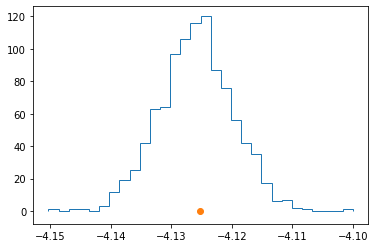

In [12]:
# first we plot the distribution of the noisy summaries
bins = 30
plt.hist(summaries_noise, bins=bins, histtype='step')
plt.scatter(summaries_fixed_noise[10], np.zeros(1))

In [13]:
# we check if the FN observation corresponsing to the fiducial q is within the noise distribution
print(summaries_noise.mean())
print(summaries_noise.std())
print(summaries_fixed_noise[10][0])

-4.1259346
0.006047501
-4.125348


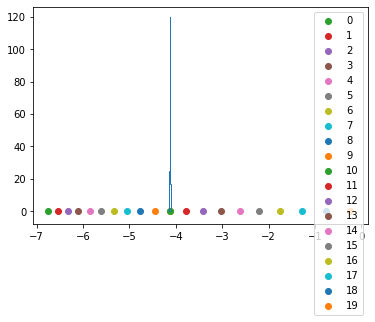

In [14]:
# then we plot the distribution of the noisy summaries with all the FN summaries
bins = 30
plt.hist(summaries_noise, bins=bins, histtype='step')
plt.scatter(summaries_fixed_noise[10], np.zeros(1))
for index in range(n_class):
    plt.scatter(summaries_fixed_noise[index], np.zeros(1), label=index)
plt.legend()

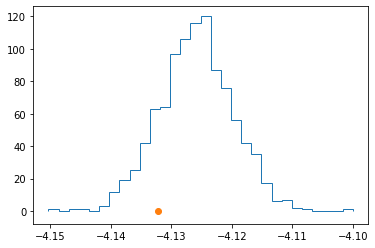

In [15]:
# we also check if the observation is within the summaries of the fiducial noisy data
bins = 30
plt.hist(summaries_noise, bins=bins, histtype='step')
plt.scatter(summary_obs, np.zeros(1))

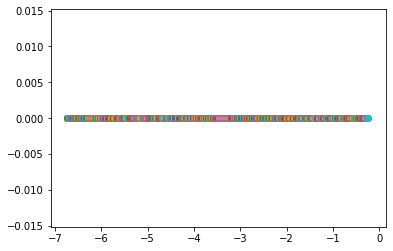

In [16]:
# and finally we look at the "posterior distribution"
# then we plot the distribution of the noisy summaries with all the FN summaries
for index in range(n_bins):
    plt.scatter(summaries_posterior[index], np.zeros(1))

# Gaussianisation of the latent space

At this stage, we finally need to set up the NF between the obtaines sample of summaries, in order to have the bijection to that space. We will use Inverse Autoregressive Flows (IAFs).

In [17]:
# we define a few variables here, and reset the graph
DTYPE=tf.float32
NP_DTYPE=np.float32
tf.reset_default_graph()
batch_size = 128
num_bijectors = 8

# we transform the summaries to a TF dataset object
dataset = tf.data.Dataset.from_tensor_slices(summaries_noise.astype(NP_DTYPE))
dataset = dataset.repeat()
dataset = dataset.shuffle(buffer_size=summaries_noise.shape[0])
dataset = dataset.prefetch(3 * batch_size)
dataset = dataset.batch(batch_size)
data_iterator = dataset.make_one_shot_iterator()
x_samples = data_iterator.get_next()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [18]:
# this is the distribution to match
#base_dist = tfd.Normal(loc=0.0, scale=1.0)
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([1], DTYPE))

In [19]:
# we define the flow here
bijectors = []
for i in range(num_bijectors):
    bijectors.append(tfb.Invert(tfb.MaskedAutoregressiveFlow(
            shift_and_log_scale_fn=tfb.masked_autoregressive_default_template(
                hidden_layers=[1024, 1024]))))
    bijectors.append(tfb.Permute(permutation=[0]))
# discard the last Permute layer.
flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))

In [20]:
# this is the transformed distribution, i.e. the distribution of the summaries
dist = tfd.TransformedDistribution(
            distribution=base_dist,
            bijector=flow_bijector)

In [21]:
# optimisation
loss = -tf.reduce_mean(dist.log_prob(x_samples))
train_op = tf.train.AdamOptimizer(1e-3).minimize(loss)

0 9.429546
500 1.7896696
1000 1.0509086
1500 -0.031627484
2000 -1.6484601
2500 -3.2969368
3000 -3.6427846
3500 -3.7274475
4000 -3.6084056
4500 -3.6842227


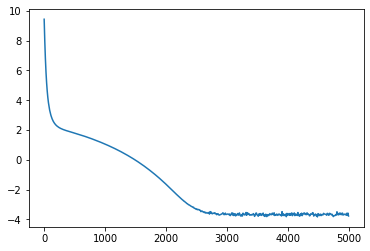

In [22]:
# and finally we train the NF as well
sess = tf.Session()
sess.run(tf.global_variables_initializer())
NUM_STEPS = 5000#int(settings[TARGET_DENSITY]['train_iters'])
global_step = []
losses = []
for i in range(NUM_STEPS):
    _, np_loss = sess.run([train_op, loss])
    if i % 10 == 0:
        global_step.append(i)
        losses.append(np_loss)
        #g_losses.append(gl)
    if i % int(5e2) == 0:
        print(i, np_loss)
start = 0
plt.plot(global_step, losses[start:])

In [23]:
# now we need to look at samples which we inject in the flow to the Gaussian domain
# just to make sure the gaussianisation was successful

In [24]:
# we look at the flow injection, which corresponds to the inverse pass
x = x_samples
samples = [x]
names = [base_dist.name]
for bijector in dist.bijector.bijectors:
    x = bijector.inverse(x)
    samples.append(x)
    names.append(bijector.name)
samples_plot = [samples[0], samples[-1], base_dist.sample(128)]
names=['Latent', 'Mapped latent', 'Original Gaussian']

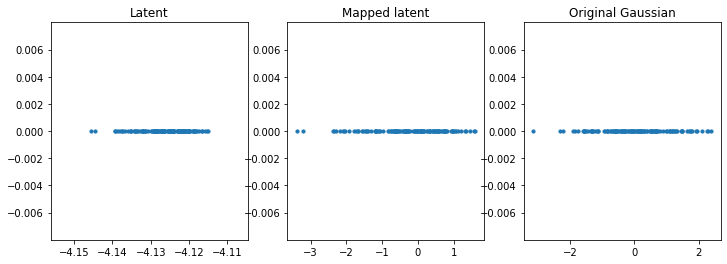

In [25]:
noise_flow = sess.run(samples_plot)
f, arr = plt.subplots(1, len(noise_flow), figsize=(4 * (len(noise_flow)), 4))
X0 = noise_flow[0]
for i in range(len(noise_flow)):
    X1 = noise_flow[i]
    arr[i].scatter(X1, np.zeros_like(X1), s=10)
    arr[i].set_title(names[i])

In [26]:
print(noise_flow[0].mean())
print(noise_flow[1].mean())
print(noise_flow[2].mean())
print(noise_flow[0].std())
print(noise_flow[1].std())
print(noise_flow[2].std())

-4.126488
-0.2756807
0.014031187
0.0061629107
0.9987161
1.0813007


In [27]:
# we need to inject all of the summaries
# in order to do that, we create many Dataset objects
# we need to transform the the FN vectors, the observation, and the posterior points
dataset = tf.data.Dataset.from_tensor_slices(summaries_fixed_noise.astype(NP_DTYPE))
dataset = dataset.repeat()
dataset = dataset.prefetch(3 * 20)
dataset = dataset.batch(20)
data_iterator = dataset.make_one_shot_iterator()
x_samples_FN = data_iterator.get_next()

In [28]:
# we need to inject all of the summaries
# in order to do that, we create many Dataset objects
# we need to transform the the FN vectors, the observation, and the posterior points
dataset = tf.data.Dataset.from_tensor_slices(summary_obs.astype(NP_DTYPE))
dataset = dataset.repeat()
dataset = dataset.prefetch(3 * 1)
dataset = dataset.batch(1)
data_iterator = dataset.make_one_shot_iterator()
x_samples_obs = data_iterator.get_next()

In [29]:
# we need to inject all of the summaries
# in order to do that, we create many Dataset objects
# we need to transform the the FN vectors, the observation, and the posterior points
dataset = tf.data.Dataset.from_tensor_slices(summaries_posterior.astype(NP_DTYPE))
dataset = dataset.repeat()
dataset = dataset.prefetch(3 * n_bins)
dataset = dataset.batch(n_bins)
data_iterator = dataset.make_one_shot_iterator()
x_samples_posterior = data_iterator.get_next()

In [30]:
# we inject the FN observation in the flow, since we need the fiducial one for the posterior evaluation
x = x_samples_FN
samples = [x]
for bijector in dist.bijector.bijectors:
    x = bijector.inverse(x)
    samples.append(x)
FN_flow_ = samples[-1]
FN_flow = sess.run(FN_flow_)
shift = FN_flow[n_class//2]

In [31]:
shift

array([-0.09095746], dtype=float32)

In [32]:
# we inject the posterior points
x = x_samples_posterior
samples = [x]
for bijector in dist.bijector.bijectors:
    x = bijector.inverse(x)
    samples.append(x)
posterior_points_ = samples[-1]
posterior_points = sess.run(posterior_points_)

In [33]:
# we need to shift the posterior points as we want the mean to be captured, and they have fixed noise
posterior_points_mu = posterior_points - shift

In [34]:
# finally, we try to evaluate the posterior
# we first inject the observation in the flow as well
x = x_samples_obs
samples = [x]
for bijector in dist.bijector.bijectors:
    x = bijector.inverse(x)
    samples.append(x)
observation_ = samples[-1]
compressed_obs = sess.run(observation_)

In [35]:
compressed_obs[0][0]

-1.205004

In [36]:
# finally we evaluate the likelihood
from scipy.stats import norm as normal
likelihood_arr = np.zeros((n_bins, 2))
for index, mu in enumerate(posterior_points_mu):
    like_value = normal.pdf(compressed_obs[0][0], loc=mu, scale=1)
    likelihood_arr[index, :] = q_posterior[index], like_value


In [37]:
likelihood_arr[:, 1] = likelihood_arr[:, 1]/likelihood_arr[:, 1].sum()

In [38]:
d_vec_obs_keep[0]

array([1.69267569, 1.69276893, 1.69300835, 1.6919559 , 1.69198449,
       1.69419654, 1.6939193 , 1.69352672, 1.69525579, 1.69170127,
       1.6972111 , 1.69093231, 1.68927147, 1.68617182, 1.68865797,
       1.68429606, 1.69805605, 1.68837428, 1.6879884 , 1.68999049,
       1.71075033, 1.69733605, 1.70533796, 1.70719723, 1.6773693 ,
       1.69557726, 1.70536483, 1.69684369, 1.68888651, 1.69596319,
       1.68256837, 1.71156615, 1.6797607 , 1.70455356, 1.69289223,
       1.69425493, 1.65435656, 1.70311292, 1.71124628, 1.68659789,
       1.69949819, 1.6939092 , 1.66586262, 1.68994299, 1.67830984,
       1.66692531, 1.65974197, 1.68742896, 1.67243463, 1.70332611])

In [46]:
# now we need to plot all of this
# we first calculate the real posterior, and the one obtained from the data

def lognorm(data, mean, sigma):
    pref = data*np.sqrt(2*np.pi) * sigma
    expo = np.exp(-(np.log(data)-mean)**2 / (2*sigma**2))
    return expo/pref

def real_post(sigma, mean, obs):
    pref = obs*np.sqrt(2*np.pi) * sigma
    expo = np.exp(-(np.log(obs)-mean)**2 / (2*sigma**2))
    evidence = 1 #inc_gamma(0, np.log(obs)**2 / 2) / (2*obs*np.sqrt(2*np.pi))
    return (expo/pref)/(evidence)

def find_level(nums, level):
    sum = 0
    for num in nums:
        sum += num
        if sum > level:
            return num

real_posterior = 1
q_real = q_posterior[:]
for i, d in enumerate(d_vec_obs_keep[0]):
    real_posterior *= real_post((i+1)/(n_vec*100.0), q_real, d)

real_posterior = real_posterior / real_posterior.sum()

indexs_to_order_by = q_real.argsort()
q_real = q_real[indexs_to_order_by]
real_posterior = real_posterior[indexs_to_order_by]

posterior = []
for value in q_posterior:
    likelihood = 1
    for i, d in enumerate(d_vec_obs_keep[0]):
        likelihood *= lognorm(d, value, (i+1)/(n_vec*100.0))
    posterior.append(likelihood)

posterior = np.reshape(np.asarray(posterior), [n_bins])
# order points by their x-value
indexs_to_order_by = q_posterior.argsort()
q_posterior = q_posterior[indexs_to_order_by]
posterior = posterior[indexs_to_order_by]

# normalise output
normalisation = np.sum(posterior)
posterior = np.asarray(posterior)/normalisation

# we want to draw 68% confidence intervals here, and we start by
# finding the level corresponding to that
sorted_posterior = sorted(posterior, reverse=True)
# we should now start summing the elements in this sorted list,
# and stop when we reach the desired level, usually 68 or 95
req_level = 0.68
level = find_level(sorted_posterior, req_level)
rep_level = [level]*n_bins
condition = np.where(posterior >= rep_level, 1, -1)
try:
    id1, id2 = np.argwhere(np.diff(condition)).flatten()
except:
    id1, id2 = 0, 0


In [47]:
posterior

array([0., 0., 0., ..., 0., 0., 0.])

(0.52, 0.53)

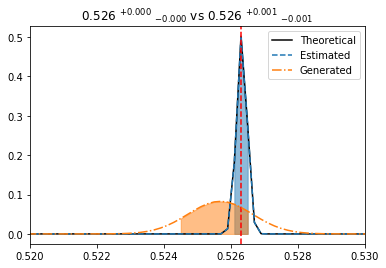

In [49]:
plt.plot(q_real, real_posterior, c='k', label='Theoretical')
plt.plot(q_posterior, posterior, linestyle='--', label='Estimated')
plt.fill_between(q_posterior[id1:id2+1], posterior[id1:id2+1],  alpha=0.5, color='C0')
plt.axvline(q_fid, linestyle='--', color='r')
max_est = q_posterior[np.argmax(posterior)]
upp_bound = q_posterior[id2] - max_est
low_bound = max_est - q_posterior[id1]

# from the ML, with the corresponding error
# confidence levels of the generated one
sorted_posterior = sorted(likelihood_arr[:, 1], reverse=True)
level = find_level(sorted_posterior, req_level)
rep_level = [level]*n_bins
try:
    condition = np.where(likelihood_arr[:, 1] >= rep_level, 1, -1)
    id1, id2 = np.argwhere(np.diff(condition)).flatten()
except:
    id1, id2 = 0, 0
plt.plot(likelihood_arr[:, 0], likelihood_arr[:, 1], linestyle='-.', label='Generated')
plt.fill_between(likelihood_arr[id1:id2+1, 0], likelihood_arr[id1:id2+1, 1], alpha=0.5, color='C1')
max_est_gen = likelihood_arr[:, 0][np.argmax(likelihood_arr[:, 1])]
upp_bound_gen = likelihood_arr[:, 0][id2] - max_est_gen
low_bound_gen = max_est_gen - likelihood_arr[:, 0][id1]
plt.title(f'{max_est:.3} $ ^{{ + {upp_bound:.3f} }}$ $ _{{ - {low_bound:.3f} }}$ vs {max_est_gen:.3} $ ^{{ + {upp_bound_gen:.3f} }}$ $ _{{ - {low_bound_gen:.3f} }}$')
plt.legend()
plt.xlim([0.52, 0.53])

In [42]:
likelihood_arr[:, 1][np.nonzero(likelihood_arr[:, 1])]

array([6.91691904e-323, 1.43511248e-319, 2.92052885e-316, 5.77499478e-313,
       1.09214305e-309, 1.99250822e-306, 3.49465490e-303, 5.86740995e-300,
       9.57247812e-297, 1.48992476e-293, 2.23959897e-290, 3.23074412e-287,
       4.51658369e-284, 6.01457908e-281, 7.76233217e-278, 9.64077219e-275,
       1.14685096e-271, 1.31817852e-268, 1.45116804e-265, 1.53489857e-262,
       1.57480075e-259, 1.54266870e-256, 1.45902100e-253, 1.32016413e-250,
       1.15690721e-247, 9.69322385e-245, 7.82686695e-242, 6.08943455e-239,
       4.55382628e-236, 3.27489036e-233, 2.26422928e-230, 1.50186643e-227,
       9.58779276e-225, 5.90823536e-222, 3.50049888e-219, 1.98576897e-216,
       1.08716295e-213, 5.72665851e-211, 2.87979203e-208, 1.40213179e-205,
       6.55900244e-203, 2.94664763e-200, 1.27257077e-197, 5.28280752e-195,
       2.11156258e-192, 8.08185657e-190, 2.98055992e-187, 1.05856297e-184,
       3.61649207e-182, 1.18414525e-179, 3.72879548e-177, 1.13173527e-174,
       3.28252630e-172, 9

In [43]:
# this is inherited and not needed - it is just another test

# visualization
x = base_dist.sample(8000)
samples = [x]
names = [base_dist.name]
for bijector in reversed(dist.bijector.bijectors):
    x = bijector.forward(x)
    samples.append(x)
    names.append(bijector.name)
samples.append([x_samples])
names.append('Real Rosenbrock')

results = sess.run(samples)
f, arr = plt.subplots(1, len(results), figsize=(4 * (len(results)), 4))
X0 = results[0]
for i in range(len(results)):
    if i == 16:
        X1 = results[i]
        arr[i].scatter(X1, np.zeros_like(X1), s=10, color='orange')
    else:
        X1 = results[i]
        idx = np.logical_and(X0[:, 0] < 0, 0==0)
        arr[i].scatter(X1[idx, 0], np.zeros_like(X1[idx, 0]), s=10, color='red')
        idx = np.logical_and(X0[:, 0] > 0, 0==0)
        arr[i].scatter(X1[idx, 0], np.zeros_like(X1[idx, 0]), s=10, color='green')
    #arr[i].set_xlim([-10, 10])
    #arr[i].set_ylim([-10, 10])
    arr[i].set_title(names[i])
#plt.savefig('../direct.png')

print(summaries.mean())
print(summaries.std())

print(results[0].mean())
print(results[0].std())

print(results[-2].mean())
print(results[-2].std())

# Posterior evaluation

After all we've done, we do have a tool that has gaussianised the likelihood. In fact, for a given parameter q, we can create an observation with fixed noise and feed it through the encoder+NF to get a point $y$. The likelihood is a unit Gaussian, with mean given by $\mu = y - z$, with $z$ the output of encoder+NF for the fiducial fixed noise realisation. In this sense, we only need to run 1 simulation per cosmological parameter.

A general observation, instead, is simply encoded and injected in the NF, thus getting the observed compressed data vector.

In order to check if we built a useful tool, we are going to calculate the posterior thus obtained. If this works, we can then build on top of this. But, as I expect, it does not work, well... we will need to re-think all of this.

In [44]:
# first thing we create an observation